#Binary Classification with a Bank Churn

##Библиотеки и загрузка данных

In [685]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import seaborn as sns
import re
import nltk

In [686]:
submission = pd.read_csv('/content/sample_submission.csv')
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

##Предварительный анализ данных

###test.csv

In [687]:
test.head()
test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               110023 non-null  int64  
 1   CustomerId       110023 non-null  int64  
 2   Surname          110023 non-null  object 
 3   CreditScore      110023 non-null  int64  
 4   Geography        110023 non-null  object 
 5   Gender           110023 non-null  object 
 6   Age              110023 non-null  float64
 7   Tenure           110023 non-null  int64  
 8   Balance          110023 non-null  float64
 9   NumOfProducts    110023 non-null  int64  
 10  HasCrCard        110023 non-null  float64
 11  IsActiveMember   110023 non-null  float64
 12  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 10.9+ MB


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,110023.000000,1.100230e+05,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000
mean,220045.000000,1.569210e+07,656.530789,38.122205,4.996637,55333.611354,1.553321,0.753043,0.495233,112315.147765
std,31761.048671,7.168499e+04,80.315415,8.861550,2.806148,62788.519675,0.544714,0.431244,0.499980,50277.048244
min,165034.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,192539.500000,1.563286e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74440.325000
50%,220045.000000,1.569018e+07,660.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117832.230000
75%,247550.500000,1.575693e+07,710.000000,42.000000,7.000000,120145.605000,2.000000,1.000000,1.000000,154631.350000
max,275056.000000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000


###train.csv

In [688]:
train.head()
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


###sample_submission.csv

In [689]:
submission.head()
submission.info()
submission.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      110023 non-null  int64  
 1   Exited  110023 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.7 MB


,id,Exited
count,110023.000000,110023.0
mean,220045.000000,0.5
std,31761.048671,0.0
min,165034.000000,0.5
25%,192539.500000,0.5
50%,220045.000000,0.5
75%,247550.500000,0.5
max,275056.000000,0.5


##Предобработка данных

###Работа с данными

####Удаление нерелевантных столбцов

In [690]:
train.drop(["id","CustomerId","Surname"], axis=1, inplace=True)
test.drop(["id","CustomerId","Surname"], axis=1, inplace=True)

####Пропуски

In [691]:
test.isna().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [692]:
train.isna().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


####Категориальные данные

In [693]:
print(train['Geography'].unique())
print(train['Gender'].unique())
print(test['Geography'].unique())
print(test['Gender'].unique())

['France' 'Spain' 'Germany']
['Male' 'Female']
['France' 'Germany' 'Spain']
['Female' 'Male']


In [694]:
label_encoder = LabelEncoder()
train['Geography'] = label_encoder.fit_transform(train['Geography'])
train['Gender'] = label_encoder.fit_transform(train['Gender'])
test['Geography'] = label_encoder.fit_transform(test['Geography'])
test['Gender'] = label_encoder.fit_transform(test['Gender'])

In [695]:
print(train['Geography'].unique())
print(train['Gender'].unique())
print(test['Geography'].unique())
print(test['Gender'].unique())

[0 2 1]
[1 0]
[0 1 2]
[0 1]


In [696]:
train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [697]:
test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,586,0,0,23.0,2,0.00,2,0.0,1.0,160976.75
1,683,0,0,46.0,2,0.00,1,1.0,0.0,72549.27
2,656,0,0,34.0,7,0.00,2,1.0,0.0,138882.09
3,681,0,1,36.0,8,0.00,1,1.0,0.0,113931.57
4,752,1,1,38.0,10,121263.62,1,1.0,0.0,139431.00


####Инжиниринг признаков

Balance_to_Age_Ratio: Соотношение баланса и возраста для определения благосостояния в разных возрастных группах.

Products_per_Year: Среднее количество товаров, продаваемых в течение года, для оценки вовлеченности в продукт.

In [698]:
train['Balance_to_Age_Ratio'] = (train['Balance']) / (train['Age'] + 1e-5)
train['Products_per_Year'] = train['NumOfProducts'] / (train['Tenure'] + 1e-5)

test['Balance_to_Age_Ratio'] = test['Balance'] / (test['Age'] + 1e-5)
test['Products_per_Year'] = test['NumOfProducts'] / (test['Tenure'] + 1e-5)

print("После добавления новых признаков в train:\n", train.columns)
print("После добавления новых признаков в test:\n", test.columns)

После добавления новых признаков в train:
 Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Balance_to_Age_Ratio', 'Products_per_Year'],
      dtype='object')
После добавления новых признаков в test:
 Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Balance_to_Age_Ratio', 'Products_per_Year'],
      dtype='object')


####Выбросы данных

<ipython-input-699-7a197ecdd766>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-699-7a197ecdd766>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-699-7a197ecdd766>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-699-7a197ecdd766>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-699-7a197ecdd766>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated a

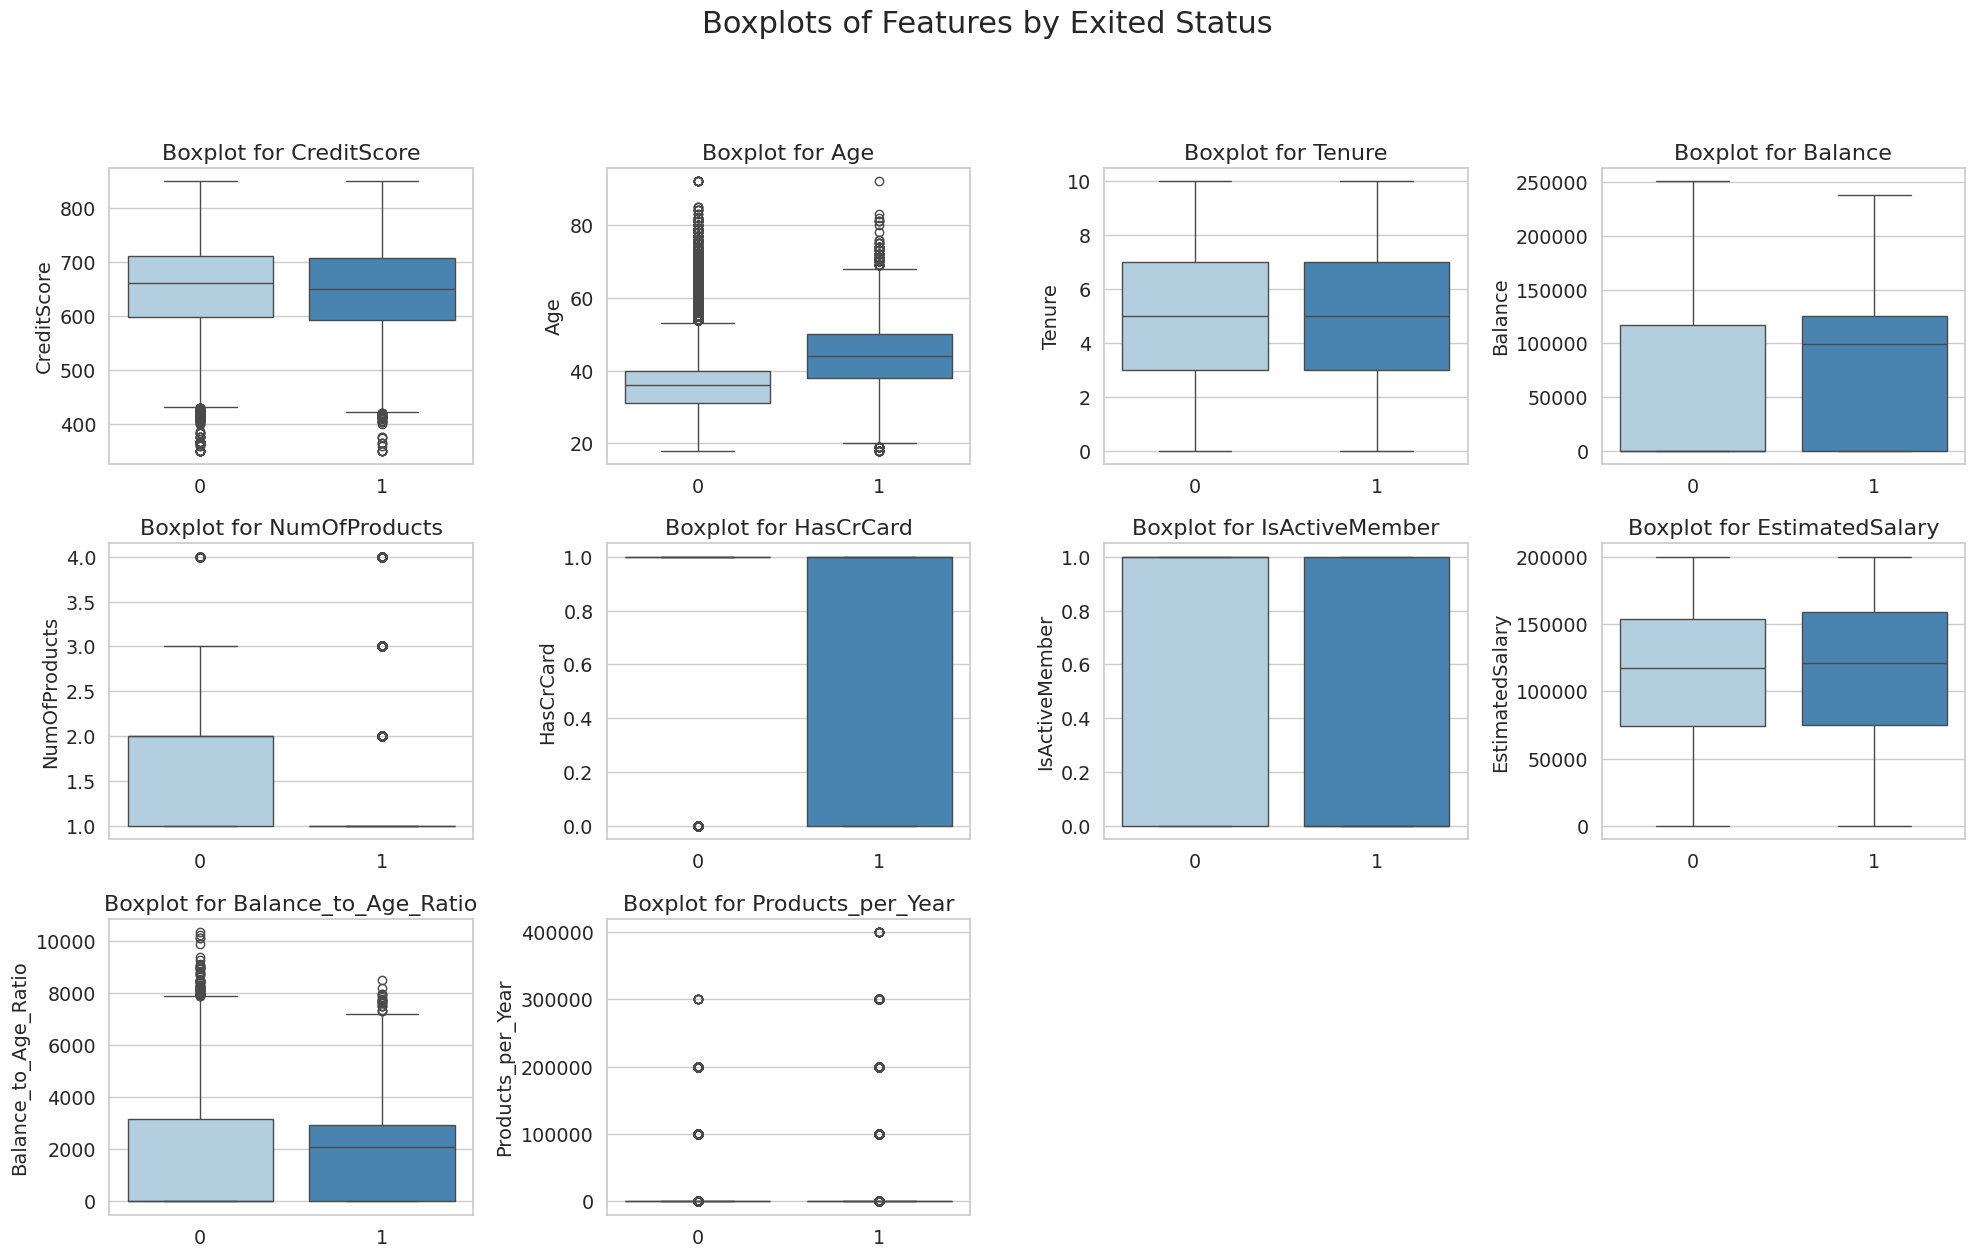

In [699]:
X_train_processed = train[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Balance_to_Age_Ratio", "Products_per_Year"]]
X_test_processed = test[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Balance_to_Age_Ratio", "Products_per_Year"]]
y_train_processed = train['Exited']

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

plt.figure(figsize=(20, 12))


for i, column in enumerate(X_train_processed.columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=y_train_processed, y=X_train_processed[column], palette="Blues")
    plt.xlabel('')
    plt.ylabel(f'{column}', fontsize=14)
    plt.title(f'Boxplot for {column}', fontsize=16)

plt.suptitle('Boxplots of Features by Exited Status', fontsize=22, y=1.05)
plt.tight_layout()
plt.show()

Для поиска выбросов применим статистический метод IQR. Значение является выбросом, если её значение превышает 1,5 раз ниже IQR первого квартиля или 1,5 раз выше третьего квартиля IQR.

Выбросы найдены и удалены из датафрейма.

In [700]:
numerical_columns = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Balance_to_Age_Ratio", "Products_per_Year"]

def outliers(data, features):
    data_cleaned = data.copy()
    for col in features:
        Q1 = data_cleaned[col].quantile(0.25)
        Q3 = data_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data_cleaned = data_cleaned[data_cleaned[col].between(lower_bound, upper_bound)]
    return data_cleaned

train_cleaned = outliers(train, numerical_columns)

train_cleaned

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_to_Age_Ratio,Products_per_Year
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.000000,0.666664
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.000000,0.200000
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,4378.896947,0.499998
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.000000,0.399999
5,588,1,1,36.0,4,131778.58,1,1.0,0.0,136024.31,1,3660.515094,0.249999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165025,635,0,0,38.0,9,0.00,2,1.0,1.0,167558.27,0,0.000000,0.222222
165027,767,0,0,44.0,4,76554.06,2,1.0,0.0,77837.63,0,1739.864605,0.499999
165028,630,0,1,50.0,8,0.00,2,1.0,1.0,5962.50,0,0.000000,0.250000
165029,667,2,0,33.0,2,0.00,1,1.0,1.0,131834.75,0,0.000000,0.499998


####Нормирование данных

In [701]:
train.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_to_Age_Ratio,Products_per_Year
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,0.648545,0.564429,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599,1507.831200,4575.275020
std,80.103340,0.816574,0.495833,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443,1786.054261,27550.534498
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000,0.000000,0.100000
25%,597.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000,0.000000,0.200000
50%,659.000000,0.000000,1.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000,0.000000,0.333332
75%,710.000000,1.000000,1.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000,3081.373172,0.599999
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000,10327.302040,400000.000000


In [702]:
test.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Balance_to_Age_Ratio,Products_per_Year
count,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000
mean,656.530789,0.643184,0.562991,38.122205,4.996637,55333.611354,1.553321,0.753043,0.495233,112315.147765,1503.098489,4643.125021
std,80.315415,0.814982,0.496018,8.861550,2.806148,62788.519675,0.544714,0.431244,0.499980,50277.048244,1784.218516,27503.952579
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000,0.100000
25%,597.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74440.325000,0.000000,0.200000
50%,660.000000,0.000000,1.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117832.230000,0.000000,0.333332
75%,710.000000,1.000000,1.000000,42.000000,7.000000,120145.605000,2.000000,1.000000,1.000000,154631.350000,3075.200620,0.666664
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,10211.146394,400000.000000


**Необходимо нормировать следующие столбцы:**

- CreditScore - значения варьируются в диапазоне от 350 до 850
- Age - значения варьируются в диапазоне от 18 до 92.
- Balance - значения варьируются от 0 до 250,898. 50% перцентиль равен 0.
- EstimatedSalary - значения варьируются от 11 до 199,992.

Рассмотрим распределение выбранных признаков для тренировочной выборки

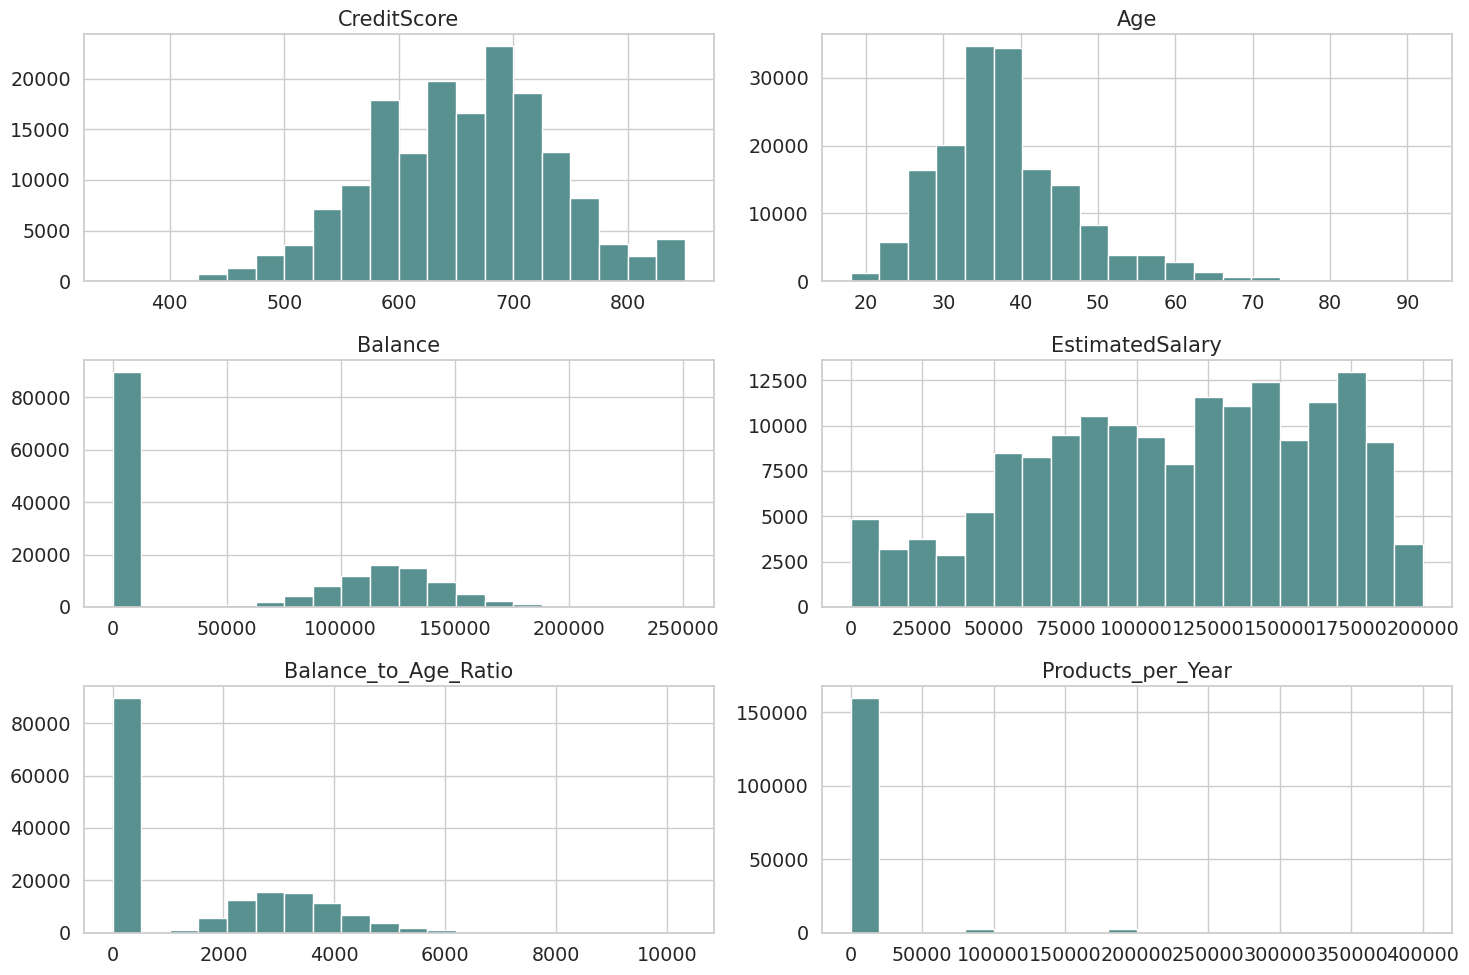

In [703]:
cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Balance_to_Age_Ratio', 'Products_per_Year']
train[cols].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

**Метод нормализации:**

- Balance - необходимо применить robust scaler, потому что он устойчив к выбросам.
- CreditScore, Age, EstimatedSalary - min-max нормализация

In [704]:
scaler = MinMaxScaler()

train['CreditScore'] = scaler.fit_transform(train[['CreditScore']])

test['CreditScore'] = scaler.transform(test[['CreditScore']])

In [705]:
scaler = MinMaxScaler()

cols = ['Age', 'EstimatedSalary']

train[cols] = scaler.fit_transform(train[cols])

test[cols] = scaler.transform(test[cols])

In [706]:
scaler = RobustScaler()

cols = ['Balance_to_Age_Ratio', 'Balance']

train[cols] = scaler.fit_transform(train[cols])

test[cols] = scaler.transform(test[cols])

In [707]:
scaler = StandardScaler()

train['Products_per_Year'] = scaler.fit_transform(train[['Products_per_Year']])

test['Products_per_Year'] = scaler.transform(test[['Products_per_Year']])

In [708]:
train.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_to_Age_Ratio,Products_per_Year
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,1.650340e+05
mean,0.612909,0.648545,0.564429,0.271971,5.020353,0.462551,1.554455,0.753954,0.497770,0.562870,0.211599,0.489337,-5.080410e-18
std,0.160207,0.816574,0.495833,0.119827,2.806159,0.523745,0.547154,0.430707,0.499997,0.251488,0.408443,0.579629,1.000003e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.660653e-01
25%,0.494000,0.000000,0.000000,0.189189,3.000000,0.000000,1.000000,1.000000,0.000000,0.373166,0.000000,0.000000,-1.660617e-01
50%,0.618000,0.000000,1.000000,0.256757,5.000000,0.000000,2.000000,1.000000,0.000000,0.589738,0.000000,0.000000,-1.660569e-01
75%,0.720000,1.000000,1.000000,0.324324,7.000000,1.000000,2.000000,1.000000,1.000000,0.775779,0.000000,1.000000,-1.660472e-01
max,1.000000,2.000000,1.000000,1.000000,10.000000,2.091872,4.000000,1.000000,1.000000,1.000000,1.000000,3.351526,1.435275e+01


In [709]:
test.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Balance_to_Age_Ratio,Products_per_Year
count,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000
mean,0.613062,0.643184,0.562991,0.271922,4.996637,0.461346,1.553321,0.753043,0.495233,0.561571,0.487802,0.002463
std,0.160631,0.814982,0.496018,0.119751,2.806148,0.523502,0.544714,0.431244,0.499980,0.251409,0.579034,0.998312
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.166065
25%,0.494000,0.000000,0.000000,0.189189,3.000000,0.000000,1.000000,1.000000,0.000000,0.372179,0.000000,-0.166062
50%,0.620000,0.000000,1.000000,0.256757,5.000000,0.000000,2.000000,1.000000,0.000000,0.589160,0.000000,-0.166057
75%,0.720000,1.000000,1.000000,0.324324,7.000000,1.001718,2.000000,1.000000,1.000000,0.773173,0.997997,-0.166045
max,1.000000,2.000000,1.000000,1.000000,10.000000,2.091872,4.000000,1.000000,1.000000,1.000000,3.313830,14.352750


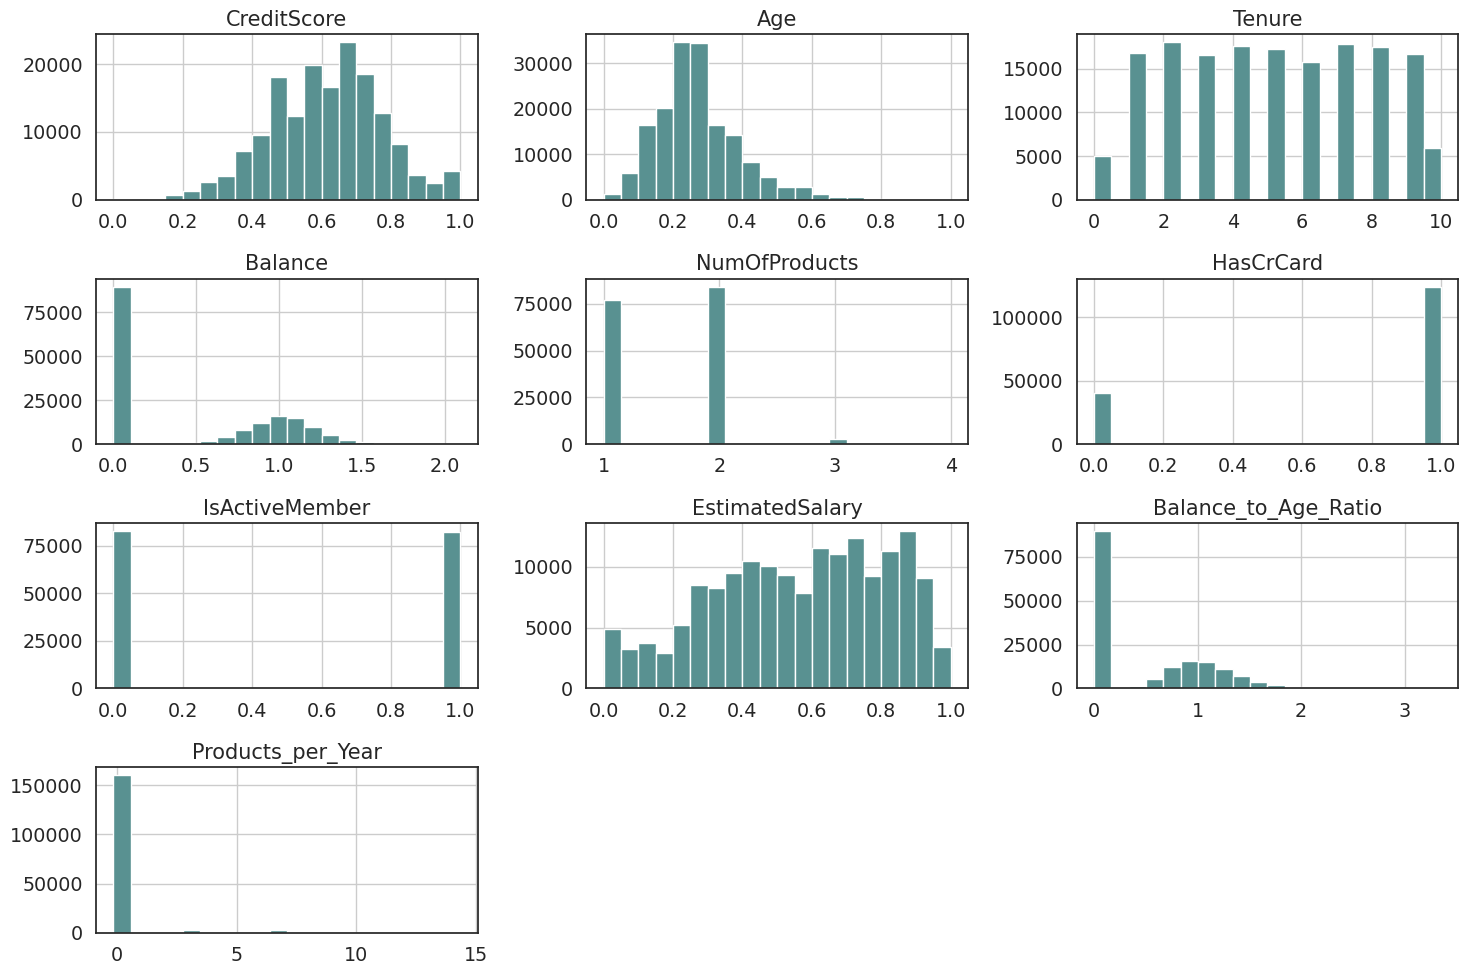

In [710]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Balance_to_Age_Ratio", "Products_per_Year"]
train[cols].hist(bins=20, figsize=(15, 10), color='#599191')

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms of Selected Columns', fontsize=18)

plt.show()

###Вывод предобработки данных

Удалены нерелевантные столбцы
Пропусков в датасете нет
Столбцы приведены к категориям
Выведены новые признаки
Выбросы отредактированы

##Обучение моделей

###Логистическая регрессия

In [711]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [712]:
# Предсказание
y_pred = model.predict(X_val)

####Метрики

In [713]:
# Вывод метрик
print("Классификационный отчет логистической регрессии:")
print(classification_report(y_val, y_pred))

Классификационный отчет логистической регрессии:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     26052
           1       0.67      0.32      0.43      6955

    accuracy                           0.82     33007
   macro avg       0.75      0.64      0.66     33007
weighted avg       0.80      0.82      0.80     33007



###Бейзлайн модель

In [714]:
X_train_processed = train[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Balance_to_Age_Ratio', 'Products_per_Year']]
X_test_processed = test[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Balance_to_Age_Ratio', 'Products_per_Year']]
y_train_processed = train['Exited']

# Обучение модели
processed_model = RandomForestClassifier(random_state=42)
processed_model.fit(X_train_processed, y_train_processed)

# Предсказания
y_pred_processed = processed_model.predict(X_test_processed)


####Метрики

In [715]:
report = classification_report(
    y_train_processed[:len(y_pred_processed)],
    y_pred_processed,
    output_dict=True
)

overall_metrics = report['macro avg']
accuracy = report['accuracy']

print(f"precision: {overall_metrics['precision']:.3f}")
print(f"recall: {overall_metrics['recall']:.3f}")
print(f"f1: {overall_metrics['f1-score']:.3f}")
print(f"accuracy: {accuracy:.3f}")

precision: 0.500
recall: 0.500
f1: 0.497
accuracy: 0.701


In [716]:
print("Метрики для обработанных данных на бейзлайн модели:")
print(classification_report(y_train_processed[:len(y_pred_processed)], y_pred_processed))

Метрики для обработанных данных на бейзлайн модели:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     86832
           1       0.21      0.15      0.18     23191

    accuracy                           0.70    110023
   macro avg       0.50      0.50      0.50    110023
weighted avg       0.67      0.70      0.68    110023



### Случайный лес

In [717]:
X = train[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Balance_to_Age_Ratio', 'Products_per_Year']]
y = train['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_val)

####Метрики

In [ ]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"accuracy: {accuracy:.3f}")
print(f"F1: {f1:.3f}")
print(f"precision: {precision:.3f}")
print(f"recall: {recall:.3f}")

In [718]:
print("Классификационный отчет модели случайного леса:")
print(classification_report(y_val, y_pred))

Классификационный отчет модели случайного леса:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     26052
           1       0.69      0.50      0.58      6955

    accuracy                           0.85     33007
   macro avg       0.78      0.72      0.74     33007
weighted avg       0.84      0.85      0.84     33007



#Общие выводы

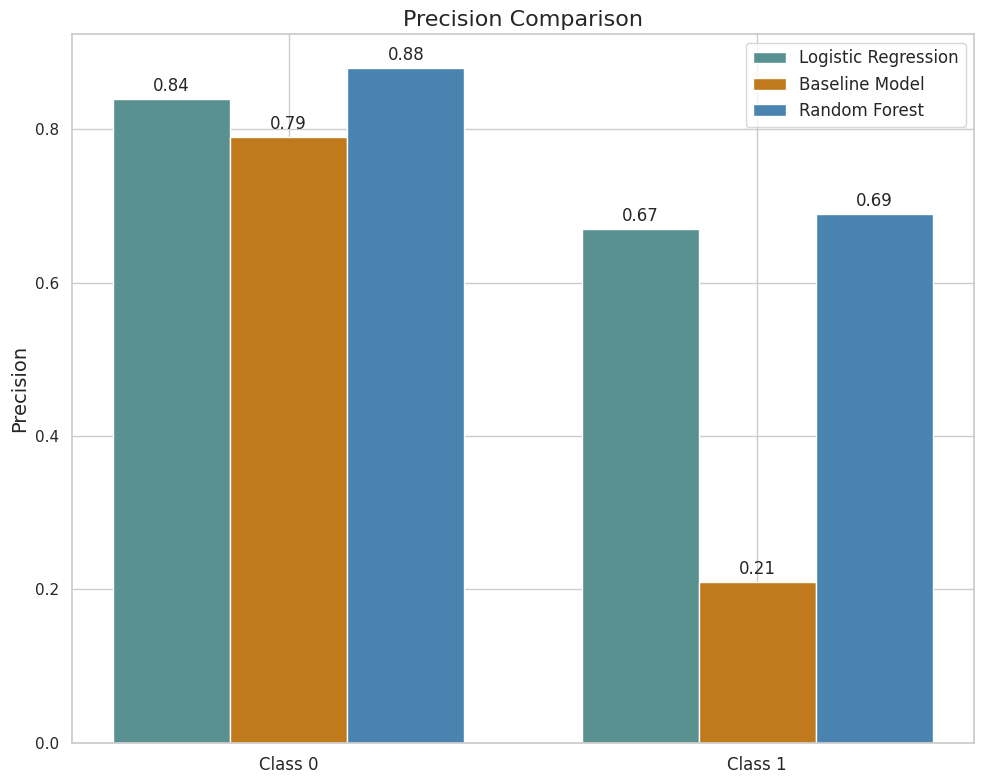

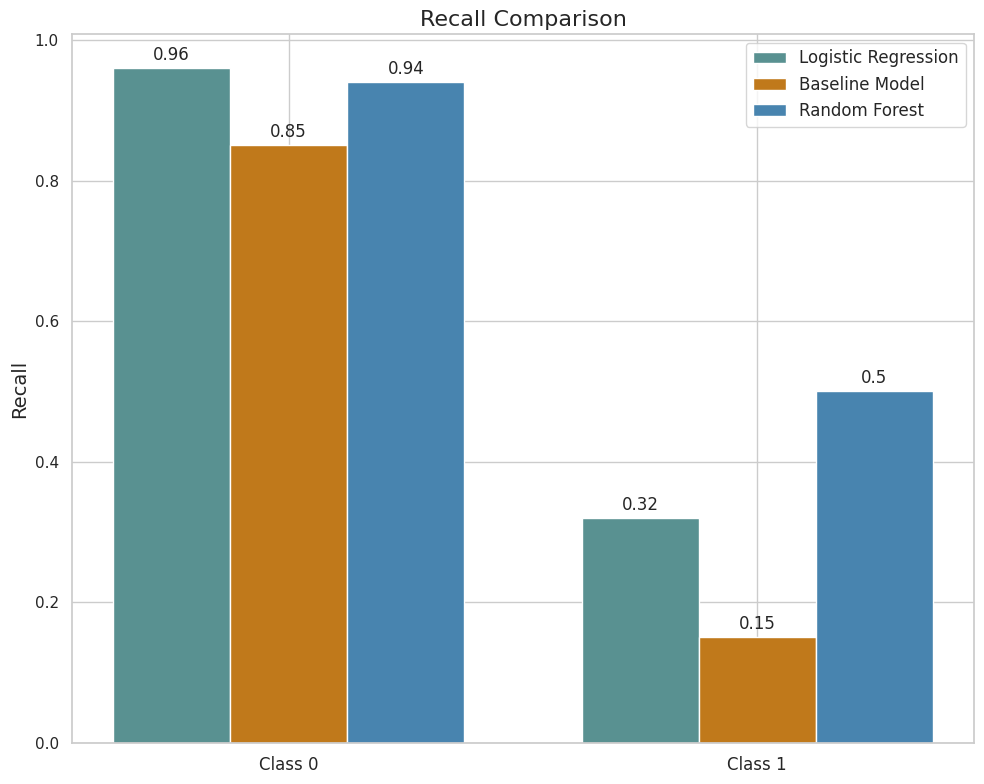

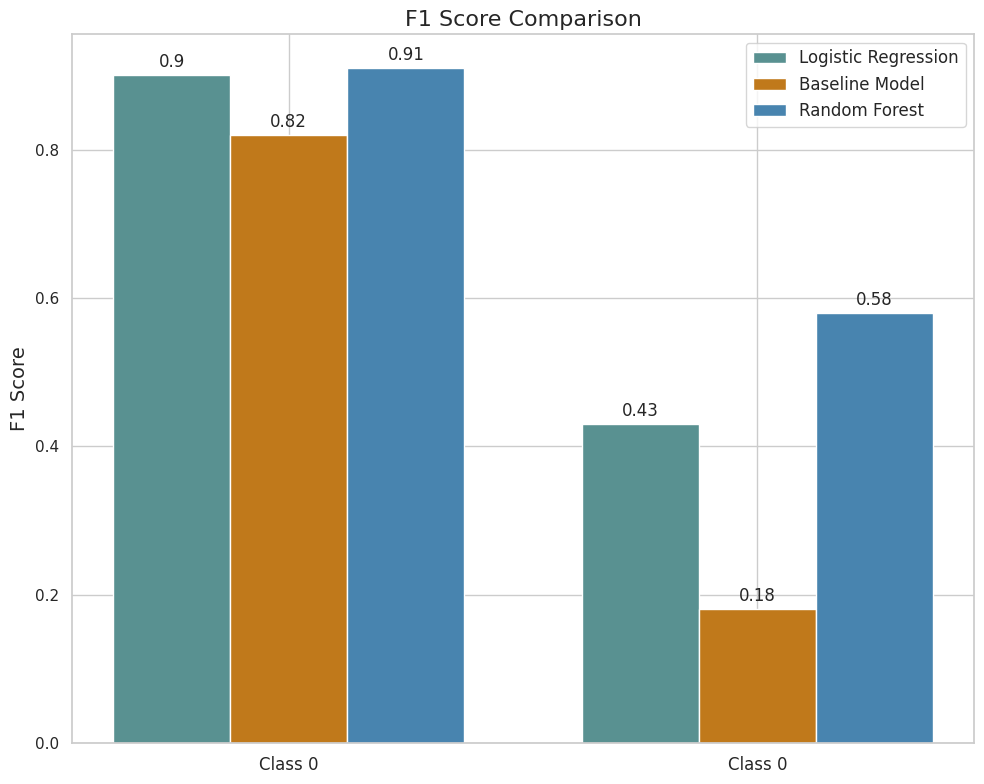

In [552]:
def create_bar_chart(labels, logistic_regression_values, baseline_values, random_forest_values, metric_name):
    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 8))

    rects1 = ax.bar(x - width, logistic_regression_values, width, label='Logistic Regression', color='#599191')
    rects2 = ax.bar(x, baseline_values, width, label='Baseline Model', color='#c0791b')
    rects3 = ax.bar(x + width, random_forest_values, width, label='Random Forest', color='#4884af')


    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    ax.set_ylabel(metric_name, fontsize=14)
    ax.set_title(f'{metric_name} Comparison', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12)
    ax.legend(fontsize=12)

    fig.tight_layout()
    plt.show()

precision_labels = ['Class 0', 'Class 1']
precision_logistic_regression = [0.84, 0.67]
precision_baseline = [0.79, 0.21]
precision_random_forest = [0.88, 0.69]

recall_labels = ['Class 0', 'Class 1']
recall_logistic_regression = [0.96, 0.32]
recall_baseline = [0.85, 0.15]
recall_random_forest = [0.94, 0.50]

f1_score_labels = ['Class 0', 'Class 0']
f1_score_logistic_regression = [0.90, 0.43]
f1_score_baseline = [0.82, 0.18]
f1_score_random_forest = [0.91, 0.58]

create_bar_chart(precision_labels, precision_logistic_regression, precision_baseline, precision_random_forest, 'Precision')
create_bar_chart(recall_labels, recall_logistic_regression, recall_baseline, recall_random_forest, 'Recall')
create_bar_chart(f1_score_labels, f1_score_logistic_regression, f1_score_baseline, f1_score_random_forest, 'F1 Score')

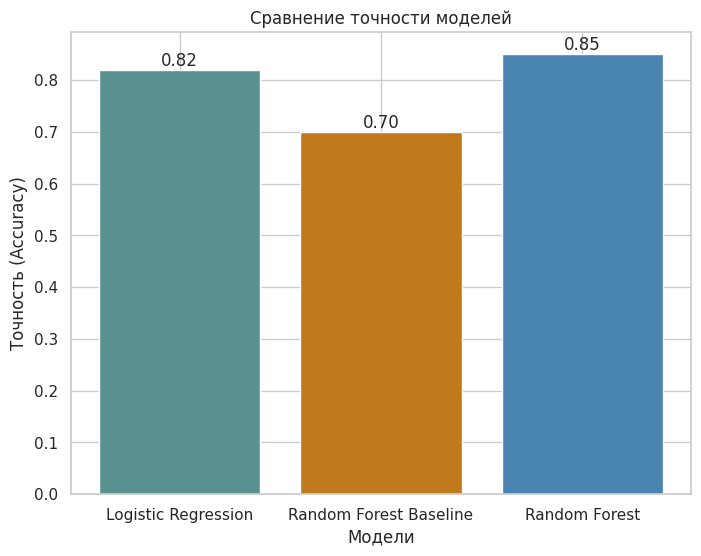

In [560]:
models = ['Logistic Regression', 'Random Forest Baseline', 'Random Forest']
accuracies = [0.82, 0.70, 0.85]
colors = ['#599191', '#c0791b', '#4884af']

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(models, accuracies, color=colors)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=12)

plt.xlabel('Модели')
plt.ylabel('Точность (Accuracy)')
plt.title('Сравнение точности моделей')

plt.show()

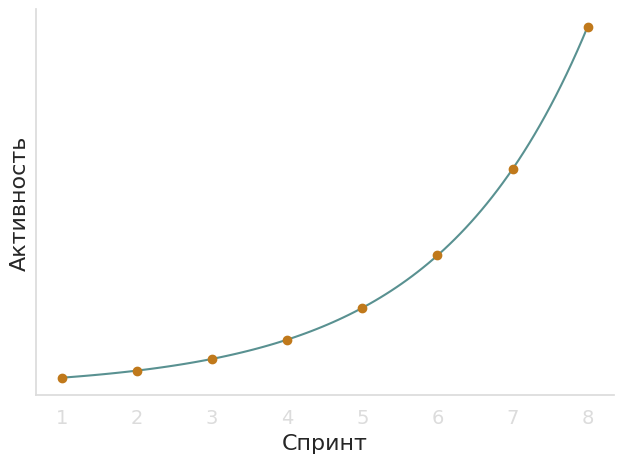

In [572]:
a = 10
b = 0.5

x_sprints = np.arange(0, 8)

def exponential_function(x):
    return a * np.exp(b * x)


x = np.linspace(0, 7, 100)
y = exponential_function(x)

plt.figure(facecolor='white')
plt.plot(x, y, color='#599191')
plt.scatter(x_sprints, exponential_function(x_sprints), c=['#c0791b'], zorder=3)
plt.grid(False)
plt.yticks([])
plt.xticks([i for i in range(len(x_sprints))], labels=[str(i+1) for i in range(len(x_sprints))])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('#DCDCDC')
plt.gca().spines['bottom'].set_color('#DCDCDC')
plt.gca().tick_params(axis='x', colors='#DCDCDC')
plt.gca().tick_params(axis='y', colors='#DCDCDC')
plt.xlabel('Спринт', fontsize=16)
plt.ylabel('Активность', fontsize=16)
plt.tight_layout()

plt.show()

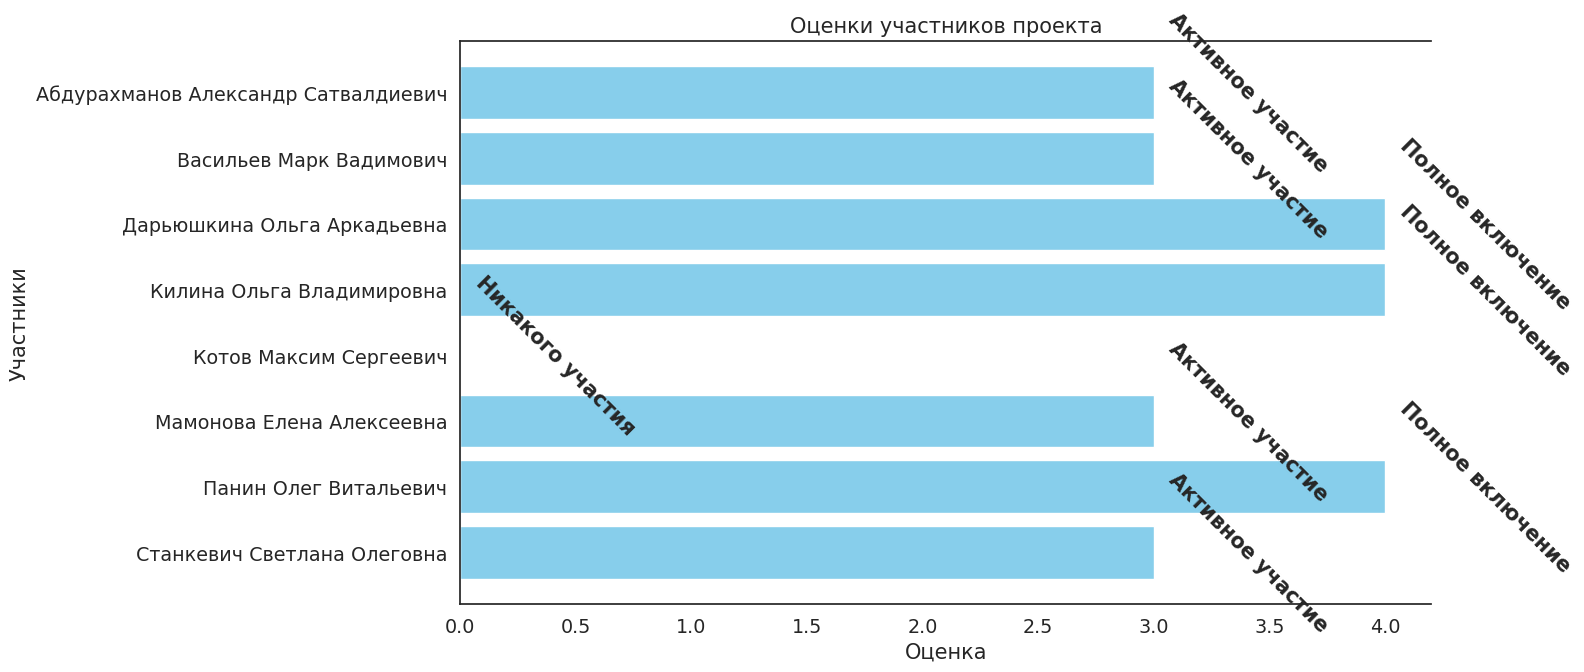

In [649]:
people = [
    "Абдурахманов Александр Сатвалдиевич",
    "Васильев Марк Вадимович",
    "Дарьюшкина Ольга Аркадьевна",
    "Килина Ольга Владимировна",
    "Котов Максим Сергеевич",
    "Мамонова Елена Алексеевна",
    "Панин Олег Витальевич",
    "Станкевич Светлана Олеговна"
]

scores = [3, 3, 4, 4, 0, 3, 4, 3]

metrics = {
    4: "Полное включение",
    3: "Активное участие",
    0: "Никакого участия"
}

fig, ax = plt.subplots(figsize=(16, 7))

ax.barh(people, scores, align='center', color='skyblue')

for i, score in enumerate(scores):
    ax.text(score + 0.05, i, metrics[score], va='center', ha='left', rotation=-45, fontweight='bold')

ax.set_ylabel('Участники')
ax.set_xlabel('Оценка')
ax.invert_yaxis()
ax.set_title('Оценки участников проекта')

ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.show()